<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import glob
import numpy as np
from scipy import stats
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from pprint import pprint
import seaborn as sns
sns.set()
sns.set_palette("colorblind")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from scipy.stats import pearsonr
import plotly.graph_objects as go
import ptitprince as pt
from trajectorytools.constants import dir_of_data
import trajectorytools as tt
import trajectorytools.geometry as ttgeometry
import trajectorytools.plot as ttplot
import trajectorytools.socialcontext as ttsocial
import pandas as pd
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
### Loading the data

hd_path = '/media/renata/'

def trajectories_path(treatment, date):
    ''' 
This function returns the path to the trajectories of each recorded session.
'''
    if treatment == 'MTZ':
        paths_pos = glob.glob(os.path.join(hd_path,date,'Session_*','MTZ_Pos_*','session_*','trajectories_wo_gaps', 'trajectories_wo_gaps.npy'))
        paths_neg = glob.glob(os.path.join(hd_path,date,'Session_*','MTZ_Neg_*','session_*','trajectories_wo_gaps', 'trajectories_wo_gaps.npy'))
    elif treatment == 'DMSO':
        paths_pos = glob.glob(os.path.join(hd_path,date,'Session_*','DMSO_Pos_*','session_*','trajectories_wo_gaps', 'trajectories_wo_gaps.npy'))
        paths_neg = glob.glob(os.path.join(hd_path,date,'Session_*','DMSO_Neg_*','session_*','trajectories_wo_gaps', 'trajectories_wo_gaps.npy'))
    else:
        paths = glob.glob(os.path.join(hd_path,date,'Session_*','*','session_*','trajectories_wo_gaps', 'trajectories_wo_gaps.npy'))
    return paths_pos, paths_neg

date1 = 'Renata_data/Experiments_20190704'
date2 = 'Renata_data/Experiments_20190806'
date3 = 'Renata_data/Experiments_20190824'
date4 = 'Renata_data/Experiments_20190829'
date5 = 'Renata_data/Experiments_20190906'
date6 = 'Renata_data/Experiments_20190919'
date7 = 'renata_data_2/Experiments_20191005'
date8 = 'renata_data_2/Experiments_20191114'
date9 = 'renata_data_2/Experiments_20191204'
date10 = 'renata_data_2/Experiments_20191214'

path_mtz_pos = trajectories_path('MTZ',date1)[0] + trajectories_path('MTZ',date2)[0] + trajectories_path('MTZ',date3)[0] + trajectories_path('MTZ',date4)[0] + trajectories_path('MTZ',date5)[0] + trajectories_path('MTZ',date6)[0] + trajectories_path('MTZ',date7)[0] + trajectories_path('MTZ',date8)[0] + trajectories_path('MTZ',date9)[0] + trajectories_path('MTZ',date10)[0]
path_mtz_neg = trajectories_path('MTZ',date1)[1] + trajectories_path('MTZ',date2)[1] + trajectories_path('MTZ',date3)[1] + trajectories_path('MTZ',date4)[1] + trajectories_path('MTZ',date5)[1] + trajectories_path('MTZ',date6)[1] + trajectories_path('MTZ',date7)[1] + trajectories_path('MTZ',date8)[1] + trajectories_path('MTZ',date9)[1] + trajectories_path('MTZ',date10)[1]
path_dmso_pos = trajectories_path('DMSO',date1)[0] + trajectories_path('DMSO',date2)[0] + trajectories_path('DMSO',date3)[0] + trajectories_path('DMSO',date4)[0] + trajectories_path('DMSO',date5)[0] + trajectories_path('DMSO',date6)[0] + trajectories_path('DMSO',date7)[0] + trajectories_path('DMSO',date8)[0]  + trajectories_path('DMSO',date9)[0] + trajectories_path('DMSO',date10)[0]
path_dmso_neg = trajectories_path('DMSO',date1)[1] + trajectories_path('DMSO',date2)[1] + trajectories_path('DMSO',date3)[1] + trajectories_path('DMSO',date4)[1] + trajectories_path('DMSO',date5)[1] + trajectories_path('DMSO',date6)[1] + trajectories_path('DMSO',date7)[1] + trajectories_path('DMSO',date8)[1] + trajectories_path('DMSO',date9)[1] + trajectories_path('DMSO',date10)[1]

In [3]:
def load_data(paths):
    traj = []
    for path in paths:
        tr = tt.Trajectories.from_idtracker('{}'.format(path),smooth_params = {'sigma':1., 'only_past':False}).normalise_by('body_length')
        tr.new_time_unit(tr.params['frame_rate'], 'second')
        traj.append(tr)
    return traj

In [4]:
mn = load_data(path_mtz_neg)
mp = load_data(path_mtz_pos)
dn = load_data(path_dmso_neg)
dp = load_data(path_dmso_pos)

KeyboardInterrupt: 

In [5]:
r1 = 'Renata_data/Experiments_20190515' # This data was altered: new_frame_rate = 15; old_frame_rate = 60
r2 = 'Renata_data/Experiments_20190530'
r3 = 'Renata_data/Experiments_20190613'

path_mtz_pos_r = trajectories_path('MTZ',r1)[0] + trajectories_path('MTZ',r2)[0] + trajectories_path('MTZ',r3)[0]
path_mtz_neg_r = trajectories_path('MTZ',r1)[1] + trajectories_path('MTZ',r2)[1] + trajectories_path('MTZ',r3)[1] 
path_dmso_pos_r = trajectories_path('DMSO',r1)[0] + trajectories_path('DMSO',r2)[0] + trajectories_path('DMSO',r3)[0]
path_dmso_neg_r = trajectories_path('DMSO',r1)[1] + trajectories_path('DMSO',r2)[1] + trajectories_path('DMSO',r3)[1]

In [6]:
paths_mp = path_mtz_pos+path_mtz_pos_r
paths_mn = path_mtz_neg_r+path_mtz_neg
paths_dp = path_dmso_pos_r+path_dmso_pos
paths_dn = path_dmso_neg_r+path_dmso_neg

In [7]:
def resampling(path):
    tr = tt.Trajectories.from_idtracker(path, smooth_params = {'sigma':1., 'only_past':False}).normalise_by('body_length')
    tr.resample(30)
    tr.new_time_unit(tr.params['frame_rate'], 'second')
    return tr

resampling_list = [path_mtz_pos_r, path_mtz_neg_r, path_dmso_pos_r, path_dmso_neg_r]

for path_list in resampling_list:
    for path in path_list:
        r_tr = resampling(path)
        if path_list == path_mtz_pos_r:
            mp.append(r_tr)
        elif path_list == path_mtz_neg_r:
            mn.append(r_tr)
        elif path_list == path_dmso_pos_r:
            dp.append(r_tr)
        elif path_list == path_dmso_neg_r:
            dn.append(r_tr)

In [8]:
# Here we can see the total number of videos per condition

dp = np.asarray(dp)
dn = np.asarray(dn)
mp = np.asarray(mp)
mn = np.asarray(mn)


print(dp.shape)
print(dn.shape)
print(mp.shape)
print(mn.shape)

(33,)
(30,)
(32,)
(33,)


In [167]:
## Rotated Trajectories

num_bins_r = 5     # Number of bin edges in radial direction
num_bins_theta = 6 # Number of bin edges in angular direction 
    
# Create polar edges
r_edges = np.linspace(0, 5, num_bins_r + 1) 
theta_edges = np.linspace(-np.pi, np.pi, num_bins_theta + 1)
    
        
# Calculate binsize for normalization (binsize increases with radius)
dr = np.pi*(r_edges[1:]**2 - r_edges[0:-1]**2)
dtheta = (theta_edges[1] - theta_edges[0])/(2*np.pi)
area = np.repeat(dtheta*dr[:,np.newaxis],theta_edges.shape[0]-1,1)

def rotated_trajectories(trajectories): 

    pos_value = []
    turn_value = []
    fwd_value = []
    
    for tr in trajectories:

        for focal in range(tr.number_of_individuals):
            s = ttgeometry.center_in_individual(tr.s,focal)
            sr = ttgeometry.fixed_to_comoving(s,tr.e[:,focal,:]) 
            sr[:,focal] = np.nan # Change rotated positions of the focal itself from '0' to 'NaN'.          
            ar = ttgeometry.fixed_to_comoving(tr.a[:,focal],tr.e[:,focal])

            
            # Reshape to add all the fish together
         
            sr_flat = sr.reshape((-1,1,2))
            ar_flat = np.repeat(ar[:,np.newaxis,:],tr.number_of_individuals,1).reshape((-1,1,2))
 

            # Transform cartesian to polar coordinates
            r = np.sqrt(sr_flat[:,0,0]**2 + sr_flat[:,0,1]**2)
            theta = np.arctan2(sr_flat[:,0,0], sr_flat[:,0,1])
        
        
            # Select the array for binned statistics/mapping 
            map_value = ar_flat[:,0,:]
        
            # Calculate the 2d histogram and binned statistics for focal turning and acceleration
            Position = stats.binned_statistic_2d(r, theta, None, 'count', bins=np.asarray([r_edges,theta_edges]))
            Turn = stats.binned_statistic_2d(r, theta, map_value[:,0], np.nanmean, bins=np.asarray([r_edges,theta_edges]))
            Fwd = stats.binned_statistic_2d(r, theta, map_value[:,1], np.nanmean, bins=np.asarray([r_edges,theta_edges]))
        
    
            pos_value.append(Position.statistic/area/np.sum(Position.statistic))
            turn_value.append(Turn.statistic)
            fwd_value.append(Fwd.statistic)
        
    
    return np.asarray(pos_value), np.asarray(turn_value), np.asarray(fwd_value)
   
   

In [168]:
pos_dp, turn_dp, fwd_dp = rotated_trajectories(dp)

/home/renata/renata_project/trajectorytools/trajectorytools/geometry.py:38: RuntimeWarning:

divide by zero encountered in true_divide

/home/renata/renata_project/trajectorytools/trajectorytools/geometry.py:38: RuntimeWarning:

invalid value encountered in true_divide

/home/renata/renata_project/trajectorytools/trajectorytools/geometry.py:38: RuntimeWarning:

divide by zero encountered in true_divide

/home/renata/renata_project/trajectorytools/trajectorytools/geometry.py:38: RuntimeWarning:

invalid value encountered in true_divide

/home/renata/renata_project/trajectorytools/trajectorytools/geometry.py:38: RuntimeWarning:

divide by zero encountered in true_divide

/home/renata/renata_project/trajectorytools/trajectorytools/geometry.py:38: RuntimeWarning:

invalid value encountered in true_divide

/home/renata/renata_project/trajectorytools/trajectorytools/geometry.py:38: RuntimeWarning:

divide by zero encountered in true_divide

/home/renata/renata_project/trajectorytools/traject

In [169]:
print(pos_dp.shape, turn_dp.shape, fwd_dp.shape)

(165, 5, 6) (165, 5, 6) (165, 5, 6)


In [170]:
# Getting the data to plot

def polar_plot(pos, turn, fwd):
    
    position = np.nanmedian(pos, axis = 0)
    turns = np.nanmedian(turn, axis = 0)
    fwd_acc = np.nanmedian(fwd, axis = 0)
    
    
    
    return position, turns, fwd_acc


dp_hist = polar_plot(pos_dp, turn_dp, fwd_dp)


In [171]:
def interpolate_polarmap_angles(histogram, theta_edges, r_edges, factor = 1):
    histogram_interpolated = np.zeros((histogram.shape[0], histogram.shape[1]*factor))
    for k in range(factor):
        histogram_interpolated[:,k::factor] = histogram
    theta_edges = np.linspace(-np.pi, np.pi, (theta_edges.shape[0]-1)*factor + 1)
    Theta, R = np.meshgrid(theta_edges, r_edges)
    return histogram_interpolated, Theta, R

def plot_polar_histogram(values, label, ax, cmap=None, sym=False):
    
    Theta, R = np.meshgrid(theta_edges, r_edges)
    mp, Theta, R = interpolate_polarmap_angles(values, theta_edges, r_edges, factor = 5)
    
    #Theta_acc, R_acc = np.meshgrid(theta_edges, r_edges_acc)
    #mp_acc, Theta_acc, R_acc = interpolate_polarmap_angles(values, theta_edges, r_edges_acc, factor = 5)

    # Select color limits: 
    if sym:
        vmax = np.max(np.abs(values))
        vmin = -vmax
    else:
        vmax = np.max(values)
        vmin = 0
     
    # Plot histogram/map
    if label == 'Position':
        im = ax.pcolormesh(Theta, R, mp, cmap=cmap, vmin=0, vmax=0.03)
    elif label == 'Turn':
        im = ax.pcolormesh(Theta, R, mp, cmap=cmap, vmin=-3, vmax=3)
    elif label == 'Acceleration':
        im = ax.pcolormesh(Theta, R, mp, cmap=cmap, vmin=-2, vmax=2)
    cb = plt.colorbar(im, ax=ax, cmap=cmap)
    cb.ax.tick_params(labelsize=24)
    ax.set_title(label,fontsize=36)
    
    # Adjusting axis and sense of rotation to make it compatible with [2]:
    # Direction of movement along vertical axis, angles increase in clockwise
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    



In [172]:
def final_plt(values, title):
    
    figure(num=None, figsize=(40, 10), facecolor='w', edgecolor='k')
    
    
    plot_polar_histogram(values[0], 'Position', plt.subplot(131, polar=True), cmap=plt.get_cmap('winter'))
    plot_polar_histogram(values[1], 'Turn', plt.subplot(132, polar=True), cmap=plt.get_cmap('coolwarm'),sym=True)
    plot_polar_histogram(values[2], 'Acceleration', plt.subplot(133, polar=True), cmap=plt.get_cmap('coolwarm'), sym = True)
    
    plt.suptitle(title, fontsize=40)
    
    
    plt.subplots_adjust(top=0.8)
    

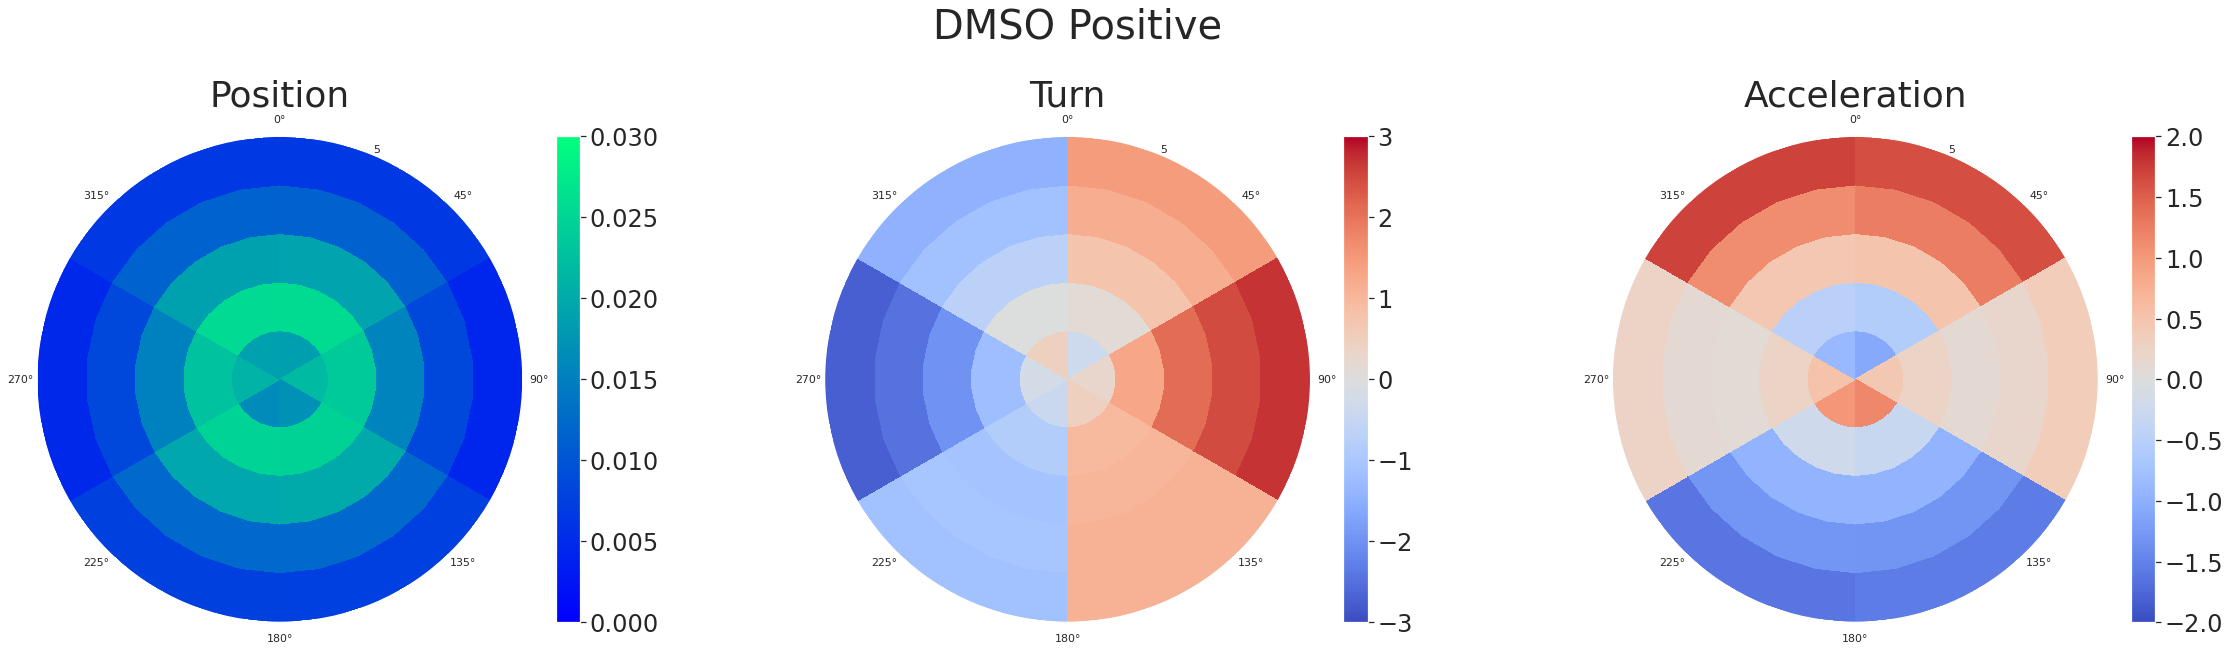

In [173]:
final_plt(dp_hist, 'DMSO Positive')